#### **Library imports**

In [1]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns
from sklearn.metrics import roc_auc_score

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

import models 
from models import get_accuracy
import inspect

#### **Load dataset**

In [2]:
dataset = 'movielens'
n_users = 943
n_items = 1682
n_new_users = 20

# load original training edges
train_edges = np.load('data/' + dataset + '/train_edges.npy')
test_edges = np.load('data/' + dataset + '/test_edges.npy')

# create list of new edges
new_users_edges = []
for u in range(n_users, n_users + n_new_users):
    for i in range(n_items):
        new_users_edges.append([u, i, 0])

# shuffle the new user edges so that it's not in any particular order
new_users_edges = np.array(new_users_edges)
np.random.seed(0)
np.random.shuffle(new_users_edges)

# concatenate with original training edges
train_edges = np.concatenate((train_edges, new_users_edges))
np.random.seed(0)
np.random.shuffle(train_edges)

# proceed with creating users, items and ratings as usual
user_list_train = train_edges[:, 0]
user_list_test = test_edges[:, 0]
item_list_train = train_edges[:, 1]
item_list_test = test_edges[:, 1]
rating_list_train = train_edges[:, 2].astype('float32')
rating_list_test = test_edges[:, 2].astype('float32')

# compute new n_users, n_items and n_samples
n_users = max(user_list_train.max(), user_list_test.max()) + 1 
n_items = max(item_list_train.max(), item_list_test.max()) + 1
n_samples_train = len(rating_list_train)
n_samples_test = len(rating_list_test)

n_users, n_items, n_samples_train, n_samples_test

(963, 1682, 193259, 40381)

#### **Code for surrogate attack using new users**

In [3]:
# model settings
algorithm = 'base-new'
surrogate = 'CF'
target = 'CF'
opt_surrogate = 'adam'
opt_target = 'adam'
lr_surrogate = 0.3
lr_target = 0.3
seed_surrogate = 0
seed_target = 4
dropout_surrogate = 0.3
dropout_target = 0.3

# start execution
start_time = time.time()

# GPU settings (set use_gpu = -1 if you want to use CPU)
use_gpu = 2
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

# some hyperparameters
T_surrogate = 25
T_target = 25
Delta = 5000 # 5% ~ 10K perturbations for movielens
n_factors_surrogate = 8
n_factors_target = 8
save_results = True
retain_graph = True 
create_graph = False

if Delta < 100:
    save_results = False

# initialize list of perturbations
perturbations = dict()
perturbations['edges'] = []
perturbations['metagrad'] = []

perturbations['accuracy-before-surrogate'] = []
perturbations['accuracy-after-surrogate'] = []
perturbations['accuracy-unseen-surrogate'] = []

perturbations['loss-before-surrogate'] = []
perturbations['loss-after-surrogate'] = []
perturbations['loss-unseen-surrogate'] = []

perturbations['accuracy-before-target'] = []
perturbations['accuracy-after-target'] = []
perturbations['accuracy-unseen-target'] = []

perturbations['loss-before-target'] = []
perturbations['loss-after-target'] = []
perturbations['loss-unseen-target'] = []

perturbations['auc-before-surrogate'] = []
perturbations['auc-after-surrogate'] = []
perturbations['auc-unseen-surrogate'] = []

perturbations['auc-before-target'] = []
perturbations['auc-after-target'] = []
perturbations['auc-unseen-target'] = []

# print hyperparam configuration
print('-> Algorithm: ', algorithm)
print()
print('-> T (surrogate): ', T_surrogate)
print('-> T (target): ', T_target)
print('-> Delta: {} ({}%)'.format(Delta, round(Delta * 100 / n_samples_train, 2)))
print('-> Embedding size (surrogate): ', n_factors_surrogate)
print('-> Embedding size (target): ', n_factors_target)
print('-> Device: ', device)
print()
print('-> Surrogate: ', surrogate)
print('-> Target: ', target)
print('-> Surrogate optimizer: ', opt_surrogate)
print('-> Target optimizer: ', opt_target)
print('-> Surrogate learning rate: ', lr_surrogate)
print('-> Target learning rate: ', lr_target)
print('-> Surrogate seed: ', seed_surrogate)
print('-> Target seed: ', seed_target)
print()
print('-> Retain graph: ', retain_graph)
print('-> Create graph: ', create_graph)
print('-> Save results: ', save_results)

# load users, items and ratings as tensors
users = torch.tensor(user_list_train, device = device)
items = torch.tensor(item_list_train, device = device)
ratings = torch.tensor(rating_list_train, device = device, requires_grad = True)

# only those edges are allowed to be perturbed whose mask entry is False
mask = torch.ones_like(ratings).bool()
mask[users >= 943] = False

# perturbs keeps track of perturbed edges by marking them as False
perturbs = torch.ones_like(ratings).bool()

# generate tensors out of validation data
users_test = torch.tensor(user_list_test, device = device)
items_test = torch.tensor(item_list_test, device = device)
ratings_test = torch.tensor(rating_list_test, device = device)

# sample random negative edges to perturb for baseline
if 'base' in algorithm:
    edges = mask.int().detach().to('cpu').numpy()
    neg_edges = np.where(edges == 0)[0]
    np.random.seed(0)
    edges_to_perturb = np.random.choice(neg_edges, size=Delta, replace = False) # sample Delta edges randomly and perturb one by one inside loop 

# for each perturbation do the following
for delta in tqdm(range(Delta), desc='-> Perturbations'):

    # define surrogate model and it's parameters
    torch.manual_seed(seed_surrogate)
    model = getattr(models, surrogate)(n_users, n_items, n_factors_surrogate, dropout_surrogate).to(device)

    # define optimizer and loss function
    if 'adam' in opt_surrogate:
        optimizer = torch.optim.Adam(model.parameters(), lr = lr_surrogate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr = lr_surrogate)
    loss_fn = nn.BCELoss(reduction = 'mean')

    # inner loop training process
    model.train()
    for i in range(T_surrogate):
        y_hat = model(users, items).reshape(ratings.shape)
        loss = loss_fn(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward(retain_graph=retain_graph, create_graph=create_graph)
        optimizer.step()
    model.eval()

    # compute and store accuracy of model after T training steps
    with torch.no_grad():
        # training accuracy and loss including perturbed edges
        y_hat = model(users, items).reshape(ratings.shape)
        perturbations['accuracy-before-surrogate'].append(get_accuracy(y_hat, ratings))
        perturbations['loss-before-surrogate'].append(loss_fn(y_hat, ratings).item())

        # compute training AUROC including perturbed edges
        y_pred = y_hat.detach().clone().to('cpu').numpy()
        y_actual = ratings.detach().clone().to('cpu').numpy() 
        perturbations['auc-before-surrogate'].append(roc_auc_score(y_actual, y_pred))

        # training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs)
        ratings_masked = torch.masked_select(ratings, perturbs)
        perturbations['accuracy-after-surrogate'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss-after-surrogate'].append(loss_fn(y_hat_masked, ratings_masked).item())

        # compute training AUROC excluding perturbed edges
        y_pred = y_hat_masked.detach().clone().to('cpu').numpy()
        y_actual = ratings_masked.detach().clone().to('cpu').numpy()
        perturbations['auc-after-surrogate'].append(roc_auc_score(y_actual, y_pred))

    # compute and store accuracy of surrogate model on unseen data
    with torch.no_grad():
        y_hat = model(users_test, items_test).reshape(ratings_test.shape)
        perturbations['accuracy-unseen-surrogate'].append(get_accuracy(y_hat, ratings_test))
        perturbations['loss-unseen-surrogate'].append(loss_fn(y_hat, ratings_test).item())

        # compute unseen AUROC
        y_pred = y_hat.detach().clone().to('cpu').numpy()
        y_actual = ratings_test.detach().clone().to('cpu').numpy()
        perturbations['auc-unseen-surrogate'].append(roc_auc_score(y_actual, y_pred))

    # compute meta gradient
    if 'meta' in algorithm:
        meta_grad = torch.autograd.grad(loss, ratings)[0]

    # define evaluation model
    torch.manual_seed(seed_target)
    eval_model = getattr(models, target)(n_users, n_items, n_factors_target, dropout_target).to(device)

    # define optimizer and loss function for evaluation
    if 'adam' in opt_target:
        optimizer_eval = torch.optim.Adam(eval_model.parameters(), lr = lr_target)
    else:
        optimizer_eval = torch.optim.SGD(eval_model.parameters(), lr = lr_target)
    loss_fn_eval = nn.BCELoss(reduction = 'mean')

    # detach ratings and perturbs for eval model
    ratings_eval = ratings.detach().clone()
    perturbs_eval = perturbs.detach().clone()

    # inner train  evaluation model
    eval_model.train()
    for i in range(T_target):
        y_hat = eval_model(users, items).reshape(ratings_eval.shape)
        loss_eval = loss_fn_eval(y_hat, ratings_eval)
        optimizer_eval.zero_grad()
        loss_eval.backward(retain_graph=retain_graph, create_graph=create_graph)
        optimizer_eval.step()
    eval_model.eval()

    # compute and store accuracy of eval model after T training steps
    with torch.no_grad():
        # training accuracy and loss including perturbed edges
        y_hat = eval_model(users, items).reshape(ratings_eval.shape)
        perturbations['accuracy-before-target'].append(get_accuracy(y_hat, ratings_eval))
        perturbations['loss-before-target'].append(loss_fn_eval(y_hat, ratings_eval).item())

        # compute training AUROC including perturbed edges
        y_pred = y_hat.detach().clone().to('cpu').numpy()
        y_actual = ratings_eval.detach().clone().to('cpu').numpy() 
        perturbations['auc-before-target'].append(roc_auc_score(y_actual, y_pred))

        # training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs_eval)
        ratings_masked = torch.masked_select(ratings_eval, perturbs_eval)
        perturbations['accuracy-after-target'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss-after-target'].append(loss_fn_eval(y_hat_masked, ratings_masked).item())

        # compute training AUROC excluding perturbed edges
        y_pred = y_hat_masked.detach().clone().to('cpu').numpy()
        y_actual = ratings_masked.detach().clone().to('cpu').numpy()
        perturbations['auc-after-target'].append(roc_auc_score(y_actual, y_pred))

    # compute and store accuracy of target model on unseen data
    with torch.no_grad():
        y_hat = eval_model(users_test, items_test).reshape(ratings_test.shape)
        perturbations['accuracy-unseen-target'].append(get_accuracy(y_hat, ratings_test))
        perturbations['loss-unseen-target'].append(loss_fn(y_hat, ratings_test).item())

        # compute unseen AUROC
        y_pred = y_hat.detach().clone().to('cpu').numpy()
        y_actual = ratings_test.detach().clone().to('cpu').numpy()
        perturbations['auc-unseen-target'].append(roc_auc_score(y_actual, y_pred))

    # select best edge and perform perturbation
    with torch.no_grad():
        if 'meta' in algorithm:
            meta_grad[mask == True] = 0
            best_edge = meta_grad.argmax().item()
            
            if mask[best_edge] == False:
                ratings[best_edge] = 1
                perturbs[best_edge] = False
                mask[best_edge] = True
            else:
                print('Perturbation #{}: No more edges left to perturb'.format(delta))

            perturbations['edges'].append(best_edge)
            perturbations['metagrad'].append(meta_grad[best_edge].item())

        else:
            best_edge = edges_to_perturb[delta]
            ratings[best_edge] = 1 
            perturbs[best_edge] = False
            mask[best_edge] = True

            perturbations['edges'].append(best_edge)
            perturbations['metagrad'].append(-1)

sleep(1)
# compute execution time
exec_time = int(time.time() - start_time)
exec_time = time.strftime("%Hh %Mm %Ss", time.gmtime(exec_time))
print('-> Execution time: {}'.format(exec_time))

# process results
perturbations = pd.DataFrame(perturbations)
filename = '{}({},{})-{}({},{})-{}-D={}-T({},{})-lr({},{})-seed({},{})-drop({},{})'.format(surrogate, n_factors_surrogate, opt_surrogate, target, n_factors_target, opt_target, algorithm, Delta, T_surrogate, T_target, lr_surrogate, lr_target, seed_surrogate, seed_target, dropout_surrogate, dropout_target)
print('-> File name: {}'.format(filename))
if save_results:
    perturbations.to_csv('results/' + dataset + '/' + filename + '.csv')


-> Algorithm:  base-new

-> T (surrogate):  25
-> T (target):  25
-> Delta: 5000 (2.59%)
-> Embedding size (surrogate):  8
-> Embedding size (target):  8
-> Device:  cuda:2

-> Surrogate:  CF
-> Target:  CF
-> Surrogate optimizer:  adam
-> Target optimizer:  adam
-> Surrogate learning rate:  0.3
-> Target learning rate:  0.3
-> Surrogate seed:  0
-> Target seed:  4

-> Retain graph:  True
-> Create graph:  False
-> Save results:  True


-> Perturbations: 100%|██████████| 5000/5000 [36:50<00:00,  2.26it/s]


-> Execution time: 00h 36m 59s
-> File name: CF(8,adam)-CF(8,adam)-base-new-D=5000-T(25,25)-lr(0.3,0.3)-seed(0,4)-drop(0.3,0.3)


In [5]:
print('File name: ', filename)
if 'meta' in algorithm:
    print('Max meta-gradient: ', perturbations['metagrad'].max())
perturbations

File name:  CF(8,adam)-CF(8,adam)-base-new-D=5000-T(25,25)-lr(0.3,0.3)-seed(0,4)-drop(0.3,0.3)


,edges,metagrad,accuracy-before-surrogate,accuracy-after-surrogate,accuracy-unseen-surrogate,loss-before-surrogate,loss-after-surrogate,loss-unseen-surrogate,accuracy-before-target,accuracy-after-target,accuracy-unseen-target,loss-before-target,loss-after-target,loss-unseen-target,auc-before-surrogate,auc-after-surrogate,auc-unseen-surrogate,auc-before-target,auc-after-target,auc-unseen-target
0,91322,-1,0.886505,0.886505,0.793740,0.255805,0.255805,0.532434,0.888026,0.888026,0.797454,0.253179,0.253179,0.524416,0.957769,0.957769,0.873770,0.958445,0.958445,0.875893
1,96340,-1,0.886515,0.886520,0.793814,0.255837,0.255820,0.532535,0.887990,0.887994,0.797553,0.253192,0.253184,0.524436,0.957760,0.957765,0.873744,0.958442,0.958444,0.875894
2,15338,-1,0.886510,0.886514,0.793863,0.255885,0.255865,0.532220,0.887990,0.887999,0.797454,0.253223,0.253190,0.524441,0.957744,0.957749,0.873749,0.958436,0.958443,0.875884
3,97419,-1,0.886520,0.886529,0.793566,0.255997,0.255881,0.531866,0.887933,0.887947,0.797553,0.253274,0.253227,0.524237,0.957729,0.957744,0.873823,0.958423,0.958434,0.875954
4,2172,-1,0.886525,0.886539,0.793690,0.256040,0.255909,0.531857,0.887912,0.887931,0.797603,0.253283,0.253227,0.524204,0.957717,0.957736,0.873820,0.958421,0.958435,0.875962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,42353,-1,0.859893,0.882298,0.789827,0.329251,0.290668,0.530079,0.860472,0.882824,0.795325,0.326845,0.287483,0.517723,0.931887,0.948748,0.870028,0.932995,0.950192,0.874970
4996,71531,-1,0.859908,0.882314,0.789777,0.329267,0.290672,0.530091,0.860503,0.882866,0.795374,0.326861,0.287476,0.517693,0.931880,0.948747,0.870038,0.932989,0.950194,0.874983
4997,29927,-1,0.859841,0.882255,0.789901,0.329282,0.290681,0.530117,0.860472,0.882833,0.795151,0.326874,0.287474,0.517736,0.931874,0.948743,0.870028,0.932985,0.950194,0.874968
4998,26429,-1,0.859872,0.882286,0.790050,0.329292,0.290683,0.530121,0.860426,0.882790,0.795300,0.326892,0.287491,0.517759,0.931869,0.948742,0.870024,0.932980,0.950189,0.874963


File name:  CF(8,adam)-CF(8,adam)-base-new-D=5000-T(25,25)-lr(0.3,0.3)-seed(0,4)-drop(0.3,0.3)


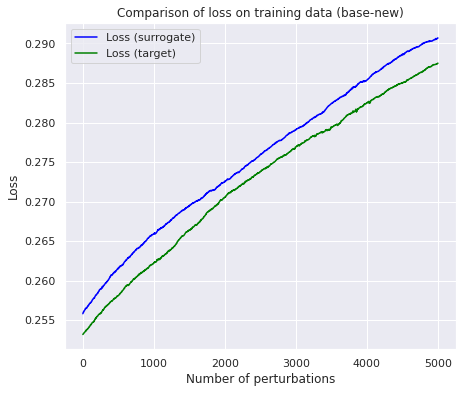

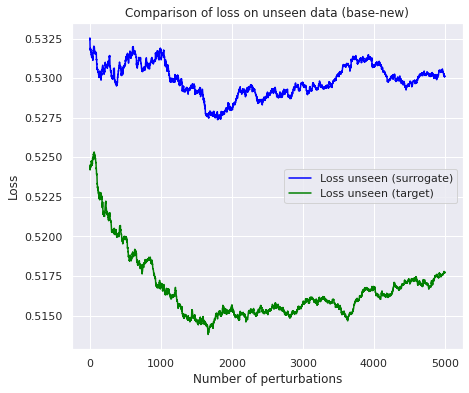

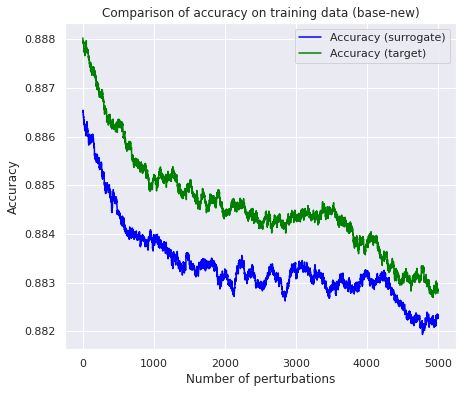

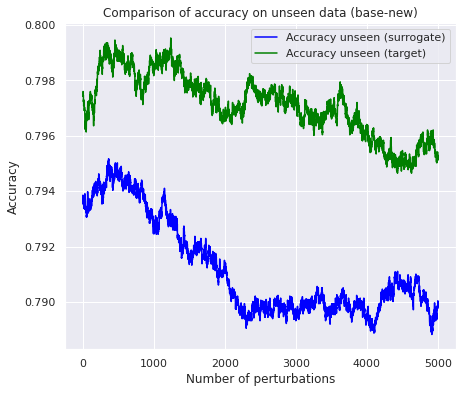

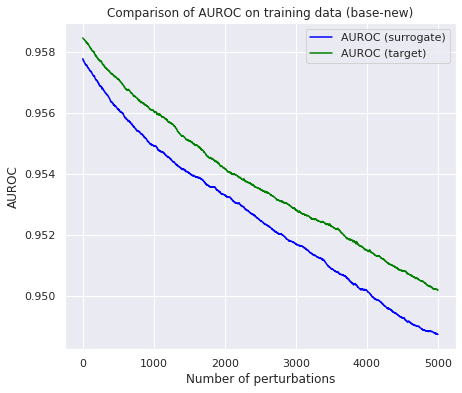

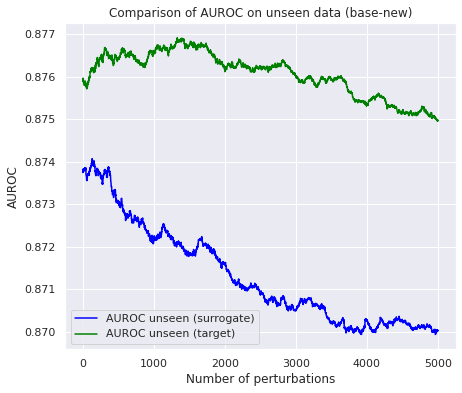

In [6]:
# Process perturbations data
perturbations_reset = perturbations.reset_index()
perturbations_reset.columns = ['# Perturbations', 'Perturbed edge', 'Meta gradient', 'Accuracy including perturbed edges (surrogate)', 'Accuracy excluding perturbed edges (surrogate)', 'Accuracy unseen (surrogate)', 'Loss including perturbed edges (surrogate)', 'Loss excluding perturbed edges (surrogate)', 'Loss unseen (surrogate)', 'Accuracy including perturbed edges (target)', 'Accuracy excluding perturbed edges (target)', 'Accuracy unseen (target)', 'Loss including perturbed edges (target)', 'Loss excluding perturbed edges (target)', 'Loss unseen (target)', 'AUROC including perturbed edges (surrogate)', 'AUROC excluding perturbed edges (surrogate)', 'AUROC unseen (surrogate)', 'AUROC including perturbed edges (target)', 'AUROC excluding perturbed edges (target)', 'AUROC unseen (target)']
perturbations_reset

# Figure specifications
sns.set_theme()
figsize = (7, 6)
print('File name: ', filename)

# Loss on training data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of loss on training data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Loss')
plt.legend(labels = ['Loss (surrogate)', 'Loss (target)'])
if save_results: 
    fig.savefig('plots/' + dataset + '/losses-' + filename + '.png')
plt.show()

# Loss on unseen data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss unseen (surrogate)', color = 'blue').set_title('Comparison of loss on unseen data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss unseen (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Loss')
plt.legend(labels = ['Loss unseen (surrogate)', 'Loss unseen (target)'])
if save_results: 
    fig.savefig('plots/' + dataset + '/losses-unseen-' + filename + '.png')
plt.show()

# Accuracy on training data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of accuracy on training data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Accuracy')
plt.legend(labels = ['Accuracy (surrogate)', 'Accuracy (target)'])
if save_results:
    fig.savefig('plots/' + dataset + '/accuracy-' + filename + '.png')
plt.show()

# Accuracy on unseen data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy unseen (surrogate)', color = 'blue').set_title('Comparison of accuracy on unseen data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy unseen (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Accuracy')
plt.legend(labels = ['Accuracy unseen (surrogate)', 'Accuracy unseen (target)'])
if save_results: 
    fig.savefig('plots/' + dataset + '/accuracy-unseen-' + filename + '.png')
plt.show()

# AUROC on training data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'AUROC excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of AUROC on training data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'AUROC excluding perturbed edges (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('AUROC')
plt.legend(labels = ['AUROC (surrogate)', 'AUROC (target)'])
if save_results:
    fig.savefig('plots/' + dataset + '/AUROC-' + filename + '.png')
plt.show()

# AUROC on unseen data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'AUROC unseen (surrogate)', color = 'blue').set_title('Comparison of AUROC on unseen data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'AUROC unseen (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('AUROC')
plt.legend(labels = ['AUROC unseen (surrogate)', 'AUROC unseen (target)'])
if save_results:
    fig.savefig('plots/' + dataset + '/AUROC-unseen-' + filename + '.png')
plt.show()